In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!nvidia-smi

Fri Jun 25 13:33:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

 # Algoritmo

## Install

In [6]:
pip install 'h5py<3.0.0'

     |████████████████████████████████| 2.9MB 4.1MB/s 
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [7]:
pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 512kB 32.1MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 3.8MB 22.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=7e89f0c8fcd08e0ef7d7b5b7851449cc88b74f8c09257fa3a9d17c05aa878c1b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.0 which is incompatible.
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0


In [8]:
pip install keras==2.5.0rc0

     |████████████████████████████████| 1.2MB 4.3MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [9]:
!pip install wordninja

     |████████████████████████████████| 542kB 4.2MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp37-none-any.whl size=541553 sha256=7fdecc7942ee2055474bc0c3e78e454a2ef800235b52bf7494080b593a6a4163
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e93c3bb33ac50e2d368b2586248f192a2e22a
Successfully built wordninja


## Imports

In [10]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras
import wordninja as wn

from sklearn import metrics
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,Lambda,Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
path = "/content/drive/MyDrive/Cyber Security/Elmo/prova_felipe/"
elmo_path = "/content/drive/MyDrive/Cyber Security/Elmo/prova_felipe/4/"

batch_size = 32
numEpochs = 10

start_fold = 10
end_fold = 11

nfolds = 10

nome_file = "Dataset_Completo.csv"

# Preprocess

In [12]:
def arrayToSentence(x):
  string=''
  for a in x:
    string=string + a + ' '
  return string

def buildDataset():
  filecsv = open(path + nome_file, newline="")
  lettore = csv.reader(filecsv, delimiter=";")

  dataset_x = []
  dataset_y = []
  temp_y = []
  for a in lettore:
    dataset_y.append(a[0])
    if a[0] == 'dga':
      temp_y.append(1)
    else:
      temp_y.append(0)
    split = wn.split(a[3])
    sen = arrayToSentence(split)
    dataset_x.append(sen)

  filecsv.close()

  return dataset_x, dataset_y, temp_y

In [13]:
def kfold(x, y, temp_y):
  # Divide the dataset into training + holdout and testing with folds
  sss = StratifiedKFold(n_splits=nfolds)

  fold = 0
  for train, test in sss.split(x, temp_y):
    print("Writing fold " + str(fold + 1) + " to csv...")
    fold += 1
    x_train, x_test, y_train, y_test, y_temp_train, y_temp_test = x[train], x[test], y[train], y[test], temp_y[train], temp_y[test]
    np.savetxt(path + "Dataset/x_train" + str(fold) + ".csv", x_train, fmt='%s', delimiter=';')
    np.savetxt(path + "Dataset/x_test" + str(fold) + ".csv", x_test, fmt='%s', delimiter=';')
    np.savetxt(path + "Dataset/y_train" + str(fold) + ".csv", y_train, fmt='%s', delimiter=';')
    np.savetxt(path + "Dataset/y_test" + str(fold) + ".csv", y_test, fmt='%s', delimiter=';')
    np.savetxt(path + "Dataset/temp_y_train" + str(fold) + ".csv", y_temp_train, fmt='%i', delimiter=';')
    np.savetxt(path + "Dataset/temp_y_test" + str(fold) + ".csv", y_temp_test, fmt='%i', delimiter=';')
  print("Files created")

In [14]:
def encode(le, labels):
    enc = le.transform(labels)
    return tf.keras.utils.to_categorical(enc)  #era solo keras.utils...

def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)

In [23]:
dataset_x, dataset_y, temp_y = buildDataset()
dataset_x = np.array(dataset_x)

le = preprocessing.LabelEncoder()
le.fit(dataset_y)

dataset_y_encode = encode(le, dataset_y)
dataset_y = np.array(dataset_y_encode)

temp_y = np.array(temp_y)

# kfold(dataset_x, dataset_y, temp_y)

# Model

Fold:  10 Epochs:  10
Model Construction...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
...done!
Train...
(67490,)
(67490, 2)
Test...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
67490/67490 [==============================] - 330s 5ms/sample
...done!
Results:
Confusion_matrix:
[[32136  1615]
 [ 1507 32232]]
Classification_report:
{'legit': {'precision': 0.9552061350057962, 'recall': 0.952149565938787, 'f1-score': 0.9536754013710419, 'support': 33751}, 'dga': {'precision': 0.9522852837769965, 'recall': 0.9553335902071787, 'f1-score': 0.9538070014500045, 'support': 33739}, 'accuracy': 0.9537412950066676, 'macro avg': {'precision': 0.9537457093913964, 'recall': 0.9537415780729828, 'f1-score': 0.9537412014105232, 'support': 67490}, 'weighted avg': {'precision': 0.9537459690610862, 'recall': 0.9537412950066676, 'f1-score': 0.9537411897110052, 'support': 67490}}


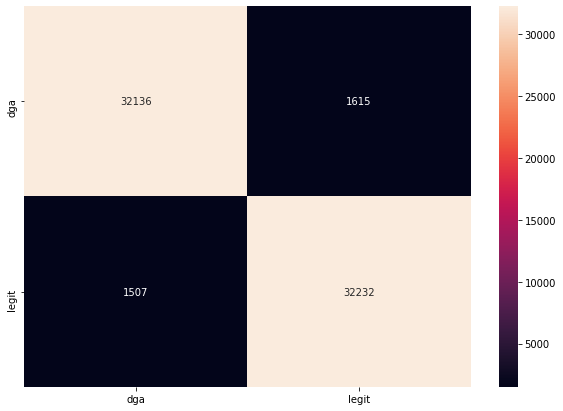

In [30]:
fold = 0
# sss = StratifiedKFold(n_splits=nfolds)
# for train, test in sss.split(dataset_x, temp_y):
#   fold += 1
#   print('Fold: ', fold)
#   x_train, x_test, y_train, y_test, y_train_temp, y_test_temp = dataset_x[train], dataset_x[test], dataset_y[train], dataset_y[test], temp_y[train], temp_y[test]

for fold in range(start_fold, end_fold):
  print('Fold: ', fold, 'Epochs: ', numEpochs)
  #Get fold by csv
  x_train = np.genfromtxt(path + "Dataset/x_train" + str(fold) + ".csv", delimiter=';', dtype=None, encoding=None)
  x_test = np.genfromtxt(path + "Dataset/x_test" + str(fold) + ".csv", delimiter=';', dtype=None, encoding=None)
  y_train = np.genfromtxt(path + "Dataset/y_train" + str(fold) + ".csv", delimiter=';', dtype=None, encoding=None)
  y_test = np.genfromtxt(path + "Dataset/y_test" + str(fold) + ".csv", delimiter=';', dtype=None, encoding=None)
  y_train_temp = np.genfromtxt(path + "Dataset/temp_y_train" + str(fold) + ".csv", delimiter=';', dtype=None, encoding=None)
  y_test_temp = np.genfromtxt(path + "Dataset/temp_y_test" + str(fold) + ".csv", delimiter=';', dtype=None, encoding=None)
  
  print('Model Construction...')
  model = None

  #Parte costruzione del modello
  # importo il modulo con la funzione di embedding ELMo
  elmo = hub.Module(elmo_path)

  # Definisco la funzione di embedding
  def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

  input_text = Input(shape=(1,), dtype=tf.string)
  embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
  dense = Dense(128, activation='relu')(embedding)
  pred = Dense(len(y_train[0]), activation='sigmoid')(dense)
  model = Model(inputs=[input_text], outputs=pred)

  model.compile('adam', 'binary_crossentropy', metrics=['accuracy',
      tf.keras.metrics.AUC(),
      tf.keras.metrics.Precision(),
      tf.keras.metrics.Recall(),
      # tf.keras.metrics.Accuracy(), #aggiunto questo
      ])

  print('...done!')

  print('Train...')
  #parte di training
  Type = 'binary-'
  '''
  with tf.compat.v1.Session() as session:
    earlystop = EarlyStopping(monitor='loss', patience=3)
    best_save = ModelCheckpoint(path + 'Saved/bestmodel' + str(fold) + '.hdf5', save_best_only=True, 
                                save_weights_only=False, 
                                monitor='val_loss', 
                                mode='min')
    tf.compat.v1.keras.backend.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())
    session.run(tf.compat.v1.tables_initializer())
    history = model.fit(x_train,y_train,
              batch_size=batch_size,
              epochs=numEpochs, 
              callbacks=[earlystop, best_save],
              validation_split=0.1
              )
    # model.save_weights('/content/drive/MyDrive/Cyber Security/Elmo/prova_felipe/Saved_weights/' + Type + 'elmo-model' + str(fold) + '.h5')

    print('\nhistory dict:', history.history)

  print('...done!')
  '''

  print('Test...')
  #Parte di test
  with tf.compat.v1.Session() as session:
    tf.compat.v1.keras.backend.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())
    session.run(tf.compat.v1.tables_initializer())
    # model.load_weights('/content/drive/MyDrive/Cyber Security/Elmo/prova_felipe/Saved_weights/'+ Type + 'elmo-model' + str(fold) + '.h5')
    best_model = load_model(path + 'Saved/bestmodel' + str(fold) + '.hdf5')
    predicts = best_model.predict(x_test, batch_size=batch_size, verbose= 1)

  # print(predicts)
  y_preds = decode(le, predicts)
  y_test_temp = np.where(y_test_temp == 1, 'dga', 'legit')
  print('...done!')

  print('Results:')
  #Plotta i risultati
  cm = metrics.confusion_matrix(y_test_temp, y_preds)
  np.savetxt(path + 'Saved/confusion_matrix' + str(fold) + '.csv', cm, delimiter=',',  fmt='%i')
  metrics1 = metrics.classification_report(y_test_temp, y_preds, output_dict=True, target_names=['legit', 'dga'])
  print('Confusion_matrix:')
  print(cm)
  print('Classification_report:')
  print(metrics1)
  try:
      df1 = pd.read_csv(path + "Saved/metrics1.csv", index_col=[0])
      df1 = df1.append(pd.DataFrame(metrics1))
      df1.to_csv(path + "Saved/metrics1.csv")
  except:
      pd.DataFrame(metrics1).to_csv(path + "Saved/metrics1.csv")

  df_cm = pd.DataFrame(cm, index = [i for i in le.classes_],
                    columns = [i for i in le.classes_])
  plt.figure(1, figsize = (10,7))
  sn.heatmap(df_cm, annot=True, fmt="d")
  plt.show()